In [1]:
import raw_data
import ta

import math

from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
daily_adjusted_df = raw_data.get_time_series_daily_adjusted("msft")
prediction_period = 1  # predict 1 day into the future

display.display(daily_adjusted_df.describe())
display.display(daily_adjusted_df.head(5))

,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
count,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5.960000e+03,5960.000000,5960.000000
mean,55.470969,56.162841,54.785379,55.494916,26.638197,4.237067e+07,0.002562,1.000671
std,34.166645,34.658273,33.658528,34.197385,18.961481,3.046236e+07,0.046281,0.025900
min,15.200000,15.620000,14.870000,15.150000,2.423500,7.111000e+05,0.000000,1.000000
25%,27.417500,27.710000,27.210000,27.457500,17.478850,2.185800e+07,0.000000,1.000000
50%,43.980000,44.500000,43.555000,43.990000,21.428700,3.814835e+07,0.000000,1.000000
75%,77.597500,79.025000,76.690000,77.690000,28.917300,5.712868e+07,0.000000,1.000000
max,178.940000,180.380000,175.750000,179.940000,112.330000,5.910522e+08,3.080000,2.000000


,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,2018-08-31,111.685,112.777,111.515,112.33,112.33,23216875,0.0,1.0
1,2018-08-30,111.670,112.610,111.440,111.95,111.95,22798702,0.0,1.0
2,2018-08-29,110.450,112.030,110.270,112.02,112.02,20818044,0.0,1.0
3,2018-08-28,109.940,110.500,109.790,110.26,110.26,19151528,0.0,1.0
4,2018-08-27,109.270,109.640,108.510,109.60,109.60,19662331,0.0,1.0


In [3]:
def preprocess_daily_adjusted_df(daily_adjusted_df, prediction_period, means=None, stds=None):
    selected_features = daily_adjusted_df[[
        "open",
        "high",
        "low",
        "adjusted_close",
        "volume"
    ]]

    # Truncate the most recent prediction_period days
    processed_df = selected_features.iloc[prediction_period:].copy()
    
    # Add technical indicators
    ta.add_all_ta_features(processed_df, "open", "high", "low", "adjusted_close", "volume", fillna=True)
    processed_df = processed_df.drop("volatility_kchi", axis=1)

    if means is None:
        means = processed_df.mean().copy()
    if stds is None:
        stds = processed_df.std().copy()

    # Normalize features
    processed_df = (processed_df - means) / stds
    
    # Add the target column
    if prediction_period == 0:
        processed_df["future_percent_change"] = 0
    else:
        start_adjusted_closes = daily_adjusted_df["adjusted_close"].iloc[prediction_period:].values
        end_adjusted_closes = daily_adjusted_df["adjusted_close"].iloc[:-prediction_period].values
        processed_df["future_percent_change"] = (end_adjusted_closes - start_adjusted_closes) / start_adjusted_closes * 100.0
        
    return processed_df, means, stds

In [4]:
def preprocess_features(df):
    processed_features = df.iloc[:, df.columns != "future_percent_change"].copy()
    return processed_features

def preprocess_targets(df):
    processed_targets = df["future_percent_change"].copy()
    return processed_targets

In [5]:
df, means, stds = preprocess_daily_adjusted_df(daily_adjusted_df, prediction_period)
display.display(df.describe())
display.display(df.head(5))

,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,future_percent_change
count,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,...,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5959.000000
mean,5.608983e-15,6.562892e-15,7.593113e-15,5.876078e-15,1.907817e-17,6.105016e-16,-1.430863e-17,-4.769543e-18,1.526254e-15,1.788579e-17,...,-2.442006e-15,2.480163e-16,-2.060443e-15,4.960325e-16,-3.205133e-15,7.631270e-17,-8.346701e-18,8.346701e-18,-4.273511e-15,0.083721
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.984872
min,-1.178556e+00,-1.169678e+00,-1.185792e+00,-1.278374e+00,-1.367611e+00,-7.778027e+00,-1.139119e+01,-4.325398e+00,-5.309731e+00,-3.670229e+01,...,-6.162033e+00,-6.026775e+00,-7.143713e+00,-6.911664e+00,-7.143713e+00,-3.177697e+00,-8.227952e+00,-8.986132e+00,-1.278374e+00,-15.606725
25%,-8.209924e-01,-8.207946e-01,-8.191125e-01,-4.831143e-01,-6.734850e-01,-4.603877e-01,-7.219137e-01,-4.813141e-01,-5.577705e-01,-4.760178e-02,...,-7.184231e-01,-1.949910e-01,-4.704856e-01,-4.758647e-01,-4.704856e-01,-2.275620e-01,-4.778304e-01,-4.708719e-01,-4.831143e-01,-0.867729
50%,-3.363860e-01,-3.365711e-01,-3.335735e-01,-2.744463e-01,-1.385863e-01,1.917199e-01,-3.820392e-02,-1.127155e-02,1.845463e-01,1.344013e-02,...,-2.169004e-02,-8.574325e-02,2.394569e-01,2.368061e-01,2.394569e-01,-3.157417e-02,7.647895e-03,1.757357e-02,-2.744463e-01,0.029180
75%,6.474629e-01,6.588573e-01,6.501331e-01,1.210258e-01,4.843691e-01,7.688946e-01,7.341295e-01,4.373455e-01,7.544168e-01,6.516727e-02,...,7.526565e-01,-1.908928e-02,7.384451e-01,7.396618e-01,7.384451e-01,1.693027e-01,4.634749e-01,4.719211e-01,1.210258e-01,1.002397
max,3.614524e+00,3.584831e+00,3.594716e+00,4.511027e+00,1.801077e+01,1.257206e+00,6.159403e+00,7.336595e+00,1.364429e+00,1.831073e+01,...,7.478065e+00,7.803166e+00,1.308217e+00,1.295186e+00,1.308217e+00,1.246479e+01,9.342215e+00,8.592048e+00,4.511027e+00,19.575074


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,future_percent_change
1,1.645363,1.629180,1.683760,4.507329,-0.642570,1.241166,0.003426,0.010619,1.364429,0.013702,...,0.457942,7.803166,1.195655,1.209596,1.195655,0.018982,0.022336,0.032278,4.507329,0.339437
2,1.609650,1.612443,1.648994,4.511027,-0.707586,1.250611,0.404767,0.010619,1.364429,0.013702,...,7.478065,7.803166,1.195655,1.209596,1.195655,0.018982,0.053848,0.063811,4.511027,-0.062489
3,1.594721,1.568291,1.634731,4.418055,-0.762291,1.255493,-0.365787,0.010619,1.364429,0.198756,...,-5.162992,7.803166,1.195655,1.209596,1.195655,0.018982,-0.769478,-0.766593,4.418055,1.596227
4,1.575109,1.543474,1.596696,4.383191,-0.745523,1.254256,-0.375635,0.010619,1.364429,0.097671,...,-5.649100,7.803166,1.195655,1.209596,1.195655,0.018982,-0.279334,-0.270590,4.383191,0.602190
5,1.528273,1.512308,1.568467,4.319801,-0.825234,1.257206,-0.328820,0.010619,1.364429,0.120781,...,-5.890663,7.803166,1.195655,1.209596,1.195655,0.018982,-0.529458,-0.523094,4.319801,1.107011


In [7]:
num_rows = len(df)
# Use 85% for training, 10% for validation, and most recent 5% for testing
num_training = int(num_rows * 0.85)
num_validation = int(num_rows * 0.1)
num_testing = num_rows - num_training - num_validation

testing_examples = preprocess_features(df.head(num_testing))
testing_targets = preprocess_targets(df.head(num_testing))

remaining_df = df[num_testing:].sample(frac=1)  # Shuffle remaining_df before splitting into training and validation sets

training_examples = preprocess_features(remaining_df.head(num_training))
training_targets = preprocess_targets(remaining_df.head(num_training))

validation_examples = preprocess_features(remaining_df.tail(num_validation))
validation_targets = preprocess_targets(remaining_df.tail(num_validation))

print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())
print("Testing examples summary:")
display.display(testing_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())
print("Testing targets summary:")
display.display(testing_targets.describe())

Training examples summary:


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
count,5065.000000,5065.000000,5065.000000,5065.000000,5065.000000,5065.000000,5065.000000,5065.000000,5065.000000,5065.000000,...,5065.000000,5065.000000,5065.000000,5065.000000,5065.000000,5065.000000,5065.000000,5065.000000,5065.000000,5065.000000
mean,-0.046440,-0.045741,-0.047270,-0.171241,0.031220,-0.061978,0.004100,0.013580,-0.070042,0.000275,...,0.028728,0.065261,-0.131171,-0.058594,-0.060830,-0.058594,0.015353,0.002692,0.002357,-0.171241
std,0.998057,0.998680,0.997156,0.671481,1.021811,0.981367,1.021786,1.018967,0.973608,1.042499,...,0.995522,0.946889,0.369371,0.983288,0.986044,0.983288,1.010747,1.016807,1.017089,0.671481
min,-1.178556,-1.169678,-1.185792,-1.278374,-1.367611,-7.778027,-11.391186,-4.325398,-5.309731,-36.702286,...,-3.013474,-2.393211,-3.614571,-6.672188,-6.911664,-6.672188,-3.177697,-8.227952,-8.986132,-1.278374
25%,-0.825237,-0.827143,-0.823570,-0.492301,-0.639954,-0.519830,-0.746292,-0.469145,-0.604008,-0.046762,...,-0.675191,-0.635260,-0.194040,-0.517280,-0.527988,-0.517280,-0.204799,-0.481407,-0.474488,-0.492301
50%,-0.429765,-0.428914,-0.429106,-0.296126,-0.090759,0.133566,0.003426,-0.002115,0.105428,0.013463,...,0.041939,0.050438,-0.086916,0.187691,0.183337,0.187691,-0.020086,0.022336,0.032278,-0.296126
75%,0.423821,0.419487,0.419992,-0.013376,0.522777,0.692290,0.761193,0.459155,0.701209,0.064538,...,0.717862,0.791823,-0.030365,0.669936,0.672835,0.669936,0.182548,0.476975,0.485315,-0.013376
max,3.614524,3.584831,3.594716,2.336662,18.010770,1.193019,6.159403,7.336595,1.252735,18.310734,...,3.383742,2.412578,2.381851,1.221105,1.226425,1.221105,11.798259,9.342215,8.592048,2.336662


Validation examples summary:


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
count,595.000000,595.000000,595.000000,595.000000,595.000000,595.000000,595.000000,595.000000,595.000000,595.000000,...,595.000000,595.000000,595.000000,595.000000,595.000000,595.000000,595.000000,595.000000,595.000000,595.000000
mean,-0.091550,-0.090862,-0.090867,-0.161254,0.023733,-0.075129,-0.003664,-0.018325,-0.056016,-0.014073,...,-0.011136,0.020512,-0.137030,-0.056566,-0.044190,-0.056566,0.010646,0.004677,0.004854,-0.161254
std,0.989531,0.991212,0.990702,0.691159,0.948604,1.028005,0.998734,1.023948,1.027031,0.744811,...,0.993406,0.970451,0.404641,1.066158,1.036799,1.066158,1.109825,0.994140,0.991007,0.691159
min,-1.154845,-1.151787,-1.162912,-1.274840,-1.332603,-6.729517,-3.379642,-3.505495,-5.128014,-12.067915,...,-2.569227,-2.253753,-2.741642,-7.143713,-6.096577,-7.143713,-2.961521,-4.248979,-4.435271,-1.274840
25%,-0.831530,-0.833203,-0.826541,-0.491976,-0.615755,-0.511878,-0.766945,-0.549429,-0.570687,-0.036476,...,-0.723692,-0.658995,-0.200438,-0.464105,-0.466610,-0.464105,-0.222887,-0.525937,-0.519532,-0.491976
50%,-0.541001,-0.541746,-0.531177,-0.294446,-0.059634,0.137160,-0.049898,-0.023139,0.176248,0.013637,...,-0.000509,0.028601,-0.085186,0.216502,0.220892,0.216502,-0.044424,-0.002682,0.007229,-0.294446
75%,0.362056,0.361773,0.354769,-0.005666,0.521979,0.720326,0.793114,0.445619,0.738539,0.060824,...,0.748844,0.691901,-0.040132,0.653680,0.676583,0.653680,0.144808,0.448810,0.457368,-0.005666
max,3.438889,3.427848,3.483285,2.201436,5.256993,1.151068,3.907758,5.434710,1.239741,4.445627,...,2.927666,2.420275,2.150587,1.210919,1.222276,1.210919,12.464792,6.506410,6.137764,2.201436


Testing examples summary:


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,...,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000
mean,0.968866,0.955656,0.981573,3.221675,-0.576085,1.199392,-0.062169,-0.193575,1.297975,0.023344,...,-0.464490,-1.146321,2.494688,1.105138,1.118388,1.105138,-0.281257,-0.054909,-0.049582,3.221675
std,0.344882,0.343557,0.344903,0.643981,0.326039,0.030628,0.508984,0.466860,0.050828,0.646691,...,0.976743,1.219917,3.282402,0.085480,0.080912,0.085480,0.306646,0.671413,0.673812,0.643981
min,0.374497,0.364370,0.393546,2.112141,-1.147206,1.085519,-1.362984,-1.363234,1.199494,-2.891194,...,-3.151159,-6.162033,-6.026775,0.896400,0.971476,0.896400,-1.041727,-3.524515,-3.649115,2.112141
25%,0.611311,0.589744,0.632007,2.555597,-0.793596,1.180425,-0.447987,-0.507775,1.246436,-0.072985,...,-1.049056,-1.516929,-0.234211,1.031780,1.049254,1.031780,-0.499926,-0.400396,-0.392647,2.555597
50%,1.002538,0.999516,0.987556,3.278394,-0.651503,1.199810,-0.294257,-0.254668,1.326823,0.010052,...,-0.473747,-0.991577,2.830993,1.092931,1.109117,1.092931,-0.243839,-0.058738,-0.048940,3.278394
75%,1.224717,1.204258,1.239154,3.708987,-0.457303,1.223308,0.416149,0.038162,1.340501,0.092997,...,0.065474,-0.527795,5.175280,1.168500,1.172971,1.168500,0.016799,0.258934,0.268551,3.708987
max,1.645363,1.629180,1.683760,4.511027,0.935647,1.257206,1.278836,1.355030,1.364429,7.829659,...,2.490244,7.478065,7.803166,1.308217,1.295186,1.308217,0.418690,2.749394,2.690674,4.511027


Training targets summary:


count    5065.000000
mean        0.079671
std         2.019585
min       -15.606725
25%        -0.894047
50%         0.000000
75%         1.009639
max        19.575074
Name: future_percent_change, dtype: float64

Validation targets summary:


count    595.000000
mean       0.073606
std        1.959349
min      -11.399313
25%       -0.839125
50%        0.049667
75%        1.099871
max        9.260127
Name: future_percent_change, dtype: float64

Testing targets summary:


count    299.000000
mean       0.172455
std        1.340242
min       -5.133358
25%       -0.467274
50%        0.164398
75%        0.845897
max        7.570599
Name: future_percent_change, dtype: float64

In [8]:
print("Data for the most recent 5 days:")
display.display(testing_examples.head(5))
display.display(testing_targets.head(5))

Data for the most recent 5 days:


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
1,1.645363,1.629180,1.683760,4.507329,-0.642570,1.241166,0.003426,0.010619,1.364429,0.013702,...,0.065474,0.457942,7.803166,1.195655,1.209596,1.195655,0.018982,0.022336,0.032278,4.507329
2,1.609650,1.612443,1.648994,4.511027,-0.707586,1.250611,0.404767,0.010619,1.364429,0.013702,...,0.065474,7.478065,7.803166,1.195655,1.209596,1.195655,0.018982,0.053848,0.063811,4.511027
3,1.594721,1.568291,1.634731,4.418055,-0.762291,1.255493,-0.365787,0.010619,1.364429,0.198756,...,0.065474,-5.162992,7.803166,1.195655,1.209596,1.195655,0.018982,-0.769478,-0.766593,4.418055
4,1.575109,1.543474,1.596696,4.383191,-0.745523,1.254256,-0.375635,0.010619,1.364429,0.097671,...,0.065474,-5.649100,7.803166,1.195655,1.209596,1.195655,0.018982,-0.279334,-0.270590,4.383191
5,1.528273,1.512308,1.568467,4.319801,-0.825234,1.257206,-0.328820,0.010619,1.364429,0.120781,...,0.065474,-5.890663,7.803166,1.195655,1.209596,1.195655,0.018982,-0.529458,-0.523094,4.319801


1    0.339437
2   -0.062489
3    1.596227
4    0.602190
5    1.107011
Name: future_percent_change, dtype: float64

In [9]:
def construct_feature_columns(input_features):
    return [tf.feature_column.numeric_column(feature) for feature in input_features]

In [10]:
def input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key: np.array(val) for key, val in dict(features).items()}

    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)

    if shuffle:
        ds = ds.shuffle(10000)
    
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [11]:
def train_nn_regression_model(
    optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    periods = 10
    steps_per_period = steps / periods
    
    optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
    dnn_regressor = tf.estimator.DNNRegressor(
        feature_columns=construct_feature_columns(training_examples),
        hidden_units=hidden_units,
        optimizer=optimizer)
    
    training_input_fn = lambda: input_fn(training_examples, training_targets, batch_size=batch_size)
    predict_training_input_fn = lambda: input_fn(training_examples, training_targets, num_epochs=1, shuffle=False)
    predict_validation_input_fn = lambda: input_fn(validation_examples, validation_targets, num_epochs=1, shuffle=False)
    
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range(periods):
        # Train the model, starting from the prior state.
        dnn_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        # Take a break and compute predictions.
        training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item["predictions"][0] for item in training_predictions])

        validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item["predictions"][0] for item in validation_predictions])

        # Compute training and validation loss.
        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions, validation_targets))
        # Occasionally print the current loss.
        print("  period %02d : %0.3f" % (period, training_root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    print("Final RMSE (on training data):   %0.3f" % training_root_mean_squared_error)
    print("Final RMSE (on validation data): %0.3f" % validation_root_mean_squared_error)

    return dnn_regressor, training_rmse, validation_rmse

Training model...
RMSE (on training data):
  period 00 : 0.290
  period 01 : 0.156
  period 02 : 0.111
  period 03 : 0.102
  period 04 : 0.075
  period 05 : 0.068
  period 06 : 0.061
  period 07 : 0.062
  period 08 : 0.052
  period 09 : 0.057
Model training finished.
Final RMSE (on training data):   0.057
Final RMSE (on validation data): 0.064


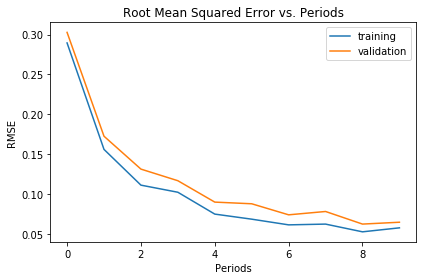

In [12]:
adam_regressor, _, _ = train_nn_regression_model(
    optimizer=tf.train.AdamOptimizer(learning_rate=0.0005),
    steps=6000,
    batch_size=30,
    hidden_units=[30, 30, 20, 20, 20],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 0.241
  period 01 : 0.171
  period 02 : 0.136
  period 03 : 0.117
  period 04 : 0.113
  period 05 : 0.101
  period 06 : 0.095
  period 07 : 0.086
  period 08 : 0.083
  period 09 : 0.077
Model training finished.
Final RMSE (on training data):   0.077
Final RMSE (on validation data): 0.095


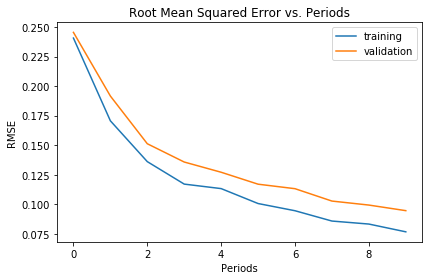

In [13]:
adagrad_regressor, _, _ = train_nn_regression_model(
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.008),
    steps=6000,
    batch_size=30,
    hidden_units=[30, 30, 20, 20, 20],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [20]:
# Select regressor to use
regressor = adam_regressor

In [21]:
# Compute testing loss
predict_testing_input_fn = lambda: input_fn(testing_examples, testing_targets, num_epochs=1, shuffle=False)
testing_predictions = regressor.predict(input_fn=predict_testing_input_fn)
testing_predictions = np.array([item["predictions"][0] for item in testing_predictions])
testing_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(testing_predictions, testing_targets))
print("RMSE on testing data: %0.3f" % testing_root_mean_squared_error)

RMSE on testing data: 0.367


(59, 30)
Darker corresponds to more negative, lighter corresponds to more positive.


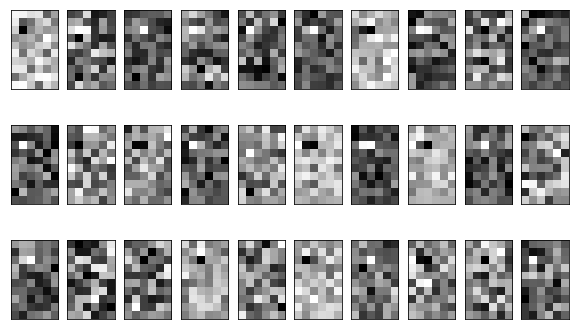

In [22]:
# Visualize weights from first layer
weights0 = regressor.get_variable_value("dnn/hiddenlayer_0/kernel")
print(weights0.shape)

num_nodes = weights0.shape[1]
num_rows = int(math.ceil(num_nodes / 10.0))
fig, axes = plt.subplots(num_rows, 10, figsize=(10, 2 * num_rows))
for coef, ax in zip(weights0.T, axes.ravel()):
    padded = np.pad(coef, (0, 1), "constant")
    cax = ax.matshow(np.expand_dims(padded, 0).reshape(10, 6), cmap=plt.cm.gray)
    ax.set_xticks(())
    ax.set_yticks(())

print("Darker corresponds to more negative, lighter corresponds to more positive.")
plt.show()

In [23]:
latest_df, _, _ = preprocess_daily_adjusted_df(daily_adjusted_df.head(prediction_period + 365), 0, means, stds)
latest_features = preprocess_features(latest_df).head(prediction_period)
latest_targets = preprocess_targets(latest_df).head(prediction_period)
predict_latest_input_fn = lambda: input_fn(latest_features, latest_targets, num_epochs=1, shuffle=False)
predictions = regressor.predict(input_fn=predict_latest_input_fn)
predictions = [item["predictions"][0] for item in predictions]
print("Current predictions (start of array is furthest into the future and end of array is 1 day into the future):")
display.display(predictions)

Current predictions (start of array is furthest into the future and end of array is 1 day into the future):


[0.05150269]